In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

import metrics
import utils

# Generalized Additive Models

error: 50.61648049523353


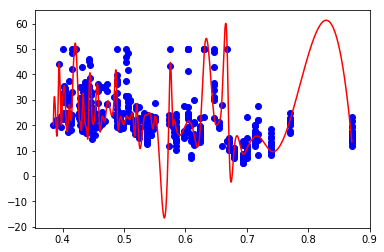

In [2]:
from sklearn.datasets import load_boston
from scipy.interpolate import UnivariateSpline

class SmoothingSpline:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        p = X.argsort()
        X, y = X[p], y[p]
        _, p = np.unique(X, return_index=True)
        X, y = X[p], y[p]
        self.us = UnivariateSpline(X, y)

    def predict(self, X):
        return self.us(X)
        

X, y = load_boston().data[:,4], load_boston().target

clf = SmoothingSpline()
clf.fit(X, y)

print('error:', np.mean((y-clf.predict(X))**2))
utils.plot_reg_contours(X, y, clf)
plt.show()

For regression, a generalized additive model has the form:
$$E[Y|X_1,X_2,\text{...},X_p] = \alpha + f_1(X_1) + f_2(X_2) + \text{...} + f_p(X_p)$$

The $f_j$'s are smooth (nonparametric) functions fit using a scatterplot smooter (cubic smootshing spline, kernel smoother).  

For binary classication, we use the logit function:

$$\mu(X) = P(Y = 1 | X)$$
$$\log \frac{\mu(X)}{1 - \mu(X)} = \alpha + f_1(X_1) + f_2(X_2) + \text{...} + f_p(X_p)$$

This model is the additive logistic regression, it's an example of the generalized additive model.  
The conditional mean $\mu(X)$ of a response $Y$ is related to an additive function via a link function $g$:
$$ g(\mu(X)) = \alpha + f_1(X_1) + f_2(X_2) + \text{...} + f_p(X_p)$$

- identity link: $g(\mu) = \mu$, additive models for Gaussian response data
- logit link: $g(\mu) = \text{logit}(\mu)$, as below

(569, 2)
(569,)
Accuracy: 0.9015817223198594


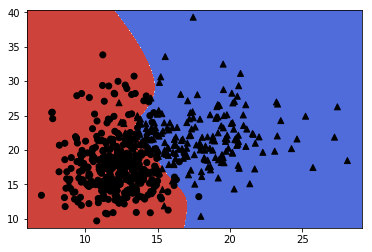

In [3]:
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer().data, load_breast_cancer().target
X = X[:,:2]
print(X.shape)
print(y.shape)

gam = LogisticGAM()
gam.fit(X, y)
gam.accuracy(X, y)


pred = gam.predict(X)
print('Accuracy:', np.mean(y == pred))

utils.plot_contours(gam, X, xtrans=None, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

In [4]:
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X, y = load_breast_cancer().data[:,:15], load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


gam = LogisticGAM()
gam.fit(X_train, y_train)

print('[GAM] Train Accuracy:', np.mean(y_train == gam.predict(X_train)))
print('[GAM]  Test Accuracy:', np.mean(y_test == gam.predict(X_test)))

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(' [LR] Train Accuracy:', np.mean(y_train == lr.predict(X_train)))
print(' [LR]  Test Accuracy:', np.mean(y_test == lr.predict(X_test)))

[GAM] Train Accuracy: 0.9868131868131869
[GAM]  Test Accuracy: 0.956140350877193
 [LR] Train Accuracy: 0.9186813186813186
 [LR]  Test Accuracy: 0.9385964912280702


/home/aiw/rep/ml-notebooks/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Fitting aditive models:

$$Y = \alpha + \sum_{j=1}^P f_j(X_j) + \epsilon$$

with $\epsilon$ error term of mean $0$.  

The criterion for this problem is:

$$\text{PRSS}(\alpha, f_1, \text{...}, f_p) = \sum_{i=1}^N (y_i - \alpha - \sum_{j=1}^p f_j(x_{ij}))^2 + \sum_{j=1}^p \lambda_j \int f''_j(t_j)^2dt_j  $$

with $\lambda_j \geq 0$ tunning parameters.

It can be shown that each $f_j$ is a cubic spline in $X_j$, with knots at each unique value $x_{ij}$.  
Without restriction, the solution is not unique.  

We can add the restriction:
$$\sum_{i=1}^N f_j(x_{ij}) = 0$$

In that, we can set $\hat{\alpha}$:
$$\hat{\alpha} = \text{ave}(y_i)$$
What's more, is $X$ has full columns ranks, the criterion is convex and the solution is unique.

### Backfitting Algorithm

1. Initialize $\hat{\alpha} = \frac{1}{N} \sum_{i=1}^N y_i$ and $\hat{f}_j = 0$

2. Cycle through $j=1,2,\text{...},p,1,\text{...}p,1,\text{...}$

    - Fit a smooting spline for $X_j$ with residual target:

        $$\hat{f}_j \leftarrow S_j \left[ \{ y_i - \hat{\alpha} - \sum_{k\neq j} \hat{f}_k(x_{ik}) \}_1^N \right]$$

    - Center $f_j$ (necessary only because of numerical errors):
    
        $$\hat{f}_j \leftarrow \hat{f}_j - \frac{1}{N} \sum_{i=1}^N \hat{f}_j(x_{ij})$$

    - Stop when $\hat{f}_j$ change less than a specific threshold
    

error: 1.3749356759958993


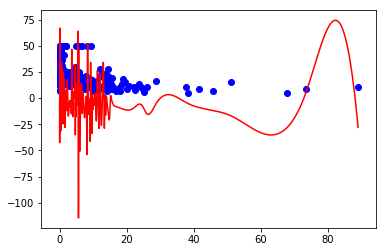

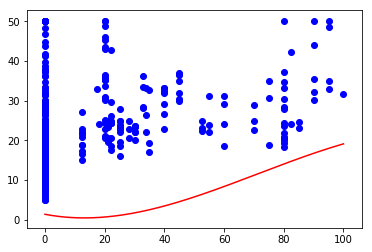

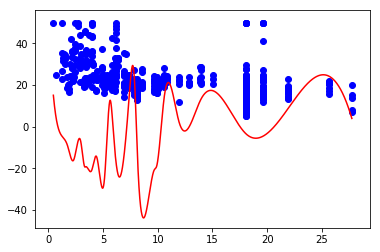

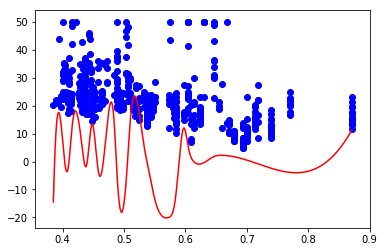

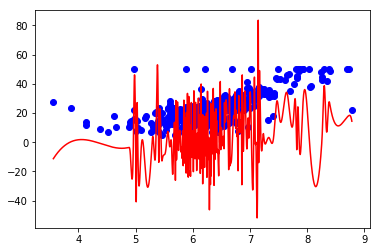

In [5]:
class ZeroModel:
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.zeros(len(X))


class GAMRegressor:
    
    def __init__(self, max_iters = 100):
        self.max_iters = max_iters
    
    def fit(self, X, y):
        N = X.shape[0]
        p = X.shape[1]
        
        a = np.mean(y)
        yc = y - a
        ss = [ZeroModel()] * p
        
        for _ in range(self.max_iters):
            for j in range(p):
                
                Xj = X[:,j]
                yj = yc.copy()
                for k in range(p):
                    if k != j:
                        yj -= ss[k].predict(X[:,k])
                
                v_old = ss[j].predict(Xj)
                
                sj = SmoothingSpline()
                sj.fit(Xj, yj)
                
                #how to subtract mean ?
                tt = sj.predict(Xj)
                
                ss[j] = sj
                v_new = ss[j].predict(Xj)
                vdiff = np.linalg.norm(v_new - v_old)
                #print(vdiff)
            
            
        self.a = a
        self.ss = ss
           
    def predict(self, X):
        y = np.ones(len(X)) * self.a
        for j in range(len(self.ss)):
            y += self.ss[j].predict(X[:,j])
        return y
            
X, y = load_boston().data[:,[0,1,2,4,5]], load_boston().target     
  
clf = GAMRegressor()
clf.fit(X, y)
print('error:', np.mean((y-clf.predict(X))**2))

for j in range(X.shape[1]):
    utils.plot_reg_contours(X[:,j], y, clf.ss[j])
    plt.show()

For logistic regression, we use a different criterion, based on penalized log-likelihood.  
The model is fit using Local Scoring Algorithm, a variant of backdiff.  
Algorithm 9.2 page 300

In [6]:
class GAMLogReg:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        N = X.shape[0]
        p = X.shape[1]
        
        ym = np.mean(y)
        h_a = np.log(ym / (1 - ym))
        ss = [ZeroModel()] * p
        
        for _ in range(10):
            
            h_n = h_a.copy()
            for j in range(p):
                h_n += ss[j].predict(X[:,j])
            h_p = 1 / (1 + np.exp(-h_n))
            z = h_n + (y - h_p) / (h_p * (1 - h_p))
            w = h_p * (1 - h_p)
            
                
            mod = GAMRegressor(max_iters=10)
            #TODO: build weighted version
            mod.fit(X, z)
            #mod.fit(X, z, w)
            h_a = mod.a
            ss = list(mod.ss)
            
            
        self.a = h_a
        self.ss = ss
           
    def predict(self, X):
        y = np.ones(len(X)) * self.a
        for j in range(len(self.ss)):
            y += self.ss[j].predict(X[:,j])
        return (y > 0).astype(np.int)
          
X, y = load_breast_cancer().data[:,:15], load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
clf = GAMLogReg()
clf.fit(X_train, y_train)
print('Train Accuracy:', np.mean(y_train == clf.predict(X_train)))
print(' Test Accuracy:', np.mean(y_test == clf.predict(X_test)))

Train Accuracy: 0.9978021978021978
 Test Accuracy: 0.8245614035087719


# Tree-Based Methods

Tree-based methods partition the feature space into a set of rectangles, and fit a simple model (like a constant to each one).  

For recursive binary partition, we first split the whole features region in two, at a specific split point, using a condition: $X_j \leq c$. we need to choose the variable $X_j$ and the constant $c$ in order to achieve the best fit.  
We recursively split the two regions, and so on, until some stopping criterion is applied.  
We get $M$ regions $R_m$ that divide the features space. This division can be represented as a binary tree. To find the prediction of a new point, we find the region it lies into, and make a specific prediction according to that region (eg: a different constant for each region)

## Regression Trees

Let's suppose we have a partition into $M$ regions $R_m$, each responding by a constant $c_m$. Then the model is:
$$f(x) = \sum_{m=1}^M c_m I(x \in R_m)$$

If we minimizes the sum of squares, the best $\hat{c}_m$ for each region is:
$$\hat{c}_m = \text{ave}(y_i|x_i \in R_m)$$

Finding the best binary partition for the sum of squares is usually infeasible, we also use a greedy approach.  
Let's consider the splitting variable $j$ and split point $s$ that cut the region into 2 half-planes $R_1$ and $R_2$:
$$R_1(j,s)  = \{X|X_j \leq s\} \text{ and } R_2(j,s)  = \{X|X_j > s\}$$

We seek $j$ and $s$ that minimizes:

$$\min_{j,s} \left[ \min_{c1} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \min_{c2} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2 \right]$$

For each splitting variable $j$, finding $s$ is quick, hence find the best pair $(j,s)$ is feasible.  
We divide the data in 2 regions, and repeat the splitting process.  
How loarge must the tree grow ? Too large might overfit, and too low might underfit. The size is a parameter that governes the model complexity.  

We start by growing a large tree $T_0$, and stopping when some minimum nod e size is reached.  This tree is pruned using cost-complexity pruning to get a subtree $T \subset T_0$  
Pruning a tree is done by collapsing one or several of its internal nodes.  

Let denote the terminal nodes $m$ representing regions $R_m$, with $T$ the number of terminal nodes in $T$.
$$N_m = \#\{x_i \in R_m\}$$
$$\hat{c}_m = \frac{1}{N_m} \sum_{x_i \in R_m} y_i$$
$$Q_m(T) = \frac{1}{N_m} \sum_{x_i \in R_m} (y_i - \hat{c}_m)^2$$

The cost complexity criterion is:
$$C_\alpha(T) = \sum_{m=1}^{|T|} N_m Q_m(T) + \alpha|T|$$  

with $\alpha \geq 0$ parameter governs tradeoff between tree size and fit of data.  
The goal is to find $T_\alpha \subseteq T_0$ to minimize $C_\alpha(T)$  

$T_\alpha$ is found with weakest link pruning: we successively collapse the internal nodes producing the smallest increase in $\sum_{m=1}^{|T|} N_m Q_m(T)$ until we produce single-node tree.    
We get a sequence of subtrees that contains $T_\alpha$

## Classification Trees

The only change is on the criteria for spliting nodes and pruning the tree.  
For regression we used $Q_m(T)$, called the node impurity measure. It was defined as the squared-error loss, but this is not suited for classification.  

Let's define the proportion of class $k$ observations in region $m$:
$$\hat{p}_{mk} = \frac{1}{N_k} \sum_{x_i \in R_m} I(y_i = k)$$  

All observations in node $m$ are classified as $k(m) = \arg \max_k \hat{p}_{mk}$ 

Different node imperuty measure exists:

- Misclassification error: $1 - \hat{p}_{mk(m)}$
- Gini index: $\sum_{k=1}^K \hat{p}_{mk} (1 - \hat{p}_{mk})$
- Cross-entropy: $- \sum_{k=1}^K \hat{p}_{mk} \log \hat{p}_{mk}$

Only gini index and cross-entropy are differientable, and they are also more sentitive change in node probabilities than misclassification error.  One of these 2 measures should be preferably used to build the tree.  
For pruning it, any of the 3 will do, but it's usually the misclassification rate.

### Other Issues

Categorical predictors with a large number of categories may lead to severe overfitting.  

A loss matrix can be used to add more severe penalties for specific class errors than others. They can be incorporated to the node impurerity measure.  

For missing predictors, a missing category can be added to categorical predictors.  
Otherwhise, we can use suggorate splits to each split, that are used when the splitting feature is missing on the data.  

In general, multiways splits (more than 2 groups) is a bad idea, it fragments the data too quickly. Binary splits are preferred.  

Instead of having splits of the form $X_j \leq s$, we can luse linear combination splits: $\sum a_jX_j \leq s$. the $a_j$ and $s$ are learned to minimize the criterion.  
It increases the predictive power but reduce its interpretability.  

Trees have high variance, a small change in the data can result in very different splits.  

Trees have a lack of smoothness of the prediction surface. This is especially true for the regression settings, where we would expect the underlying function to be smooth.  

The tree structure is not suited to capture additive structure. It can do so, with lots of data, but the model is given no special encouragement to find such structure.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = load_boston().data[:,[0,1,2,4,5]], load_boston().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)

lr = LinearRegression()
lr.fit(X_train, y_train)
print('[LR] train_error:', np.mean((y_train - lr.predict(X_train))**2))
print('[LR]  test_error:', np.mean((y_test - lr.predict(X_test))**2))

dt = DecisionTreeRegressor(criterion='mse')
dt.fit(X_train, y_train)
print('[DT] train_error:', np.mean((y_train - dt.predict(X_train))**2))
print('[DT]  test_error:', np.mean((y_test - dt.predict(X_test))**2))

[LR] train_error: 39.11552825178514
[LR]  test_error: 25.604140656420583
[DT] train_error: 0.0
[DT]  test_error: 44.59352941176471


In [8]:
from copy import deepcopy

class DTNode:
    
    def __init__(self, X, y, val):
        self.X = X
        self.y = y
        self.val = val
        self.cut = None
        self.subs = None
        
    def size(self):
        if self.cut is None:
            return 1
        else:
            return self.subs[0].size() + self.subs[1].size()
        
    def pred(self, x):
        if self.cut is None:
            return self.val
        elif x[self.cut[0]] <= self.cut[1]:
            return self.subs[0].pred(x)
        else:
            return self.subs[1].pred(x)
        
    def split(self, j, s, eval_fn):
        if self.cut is not None:
            raise Exception('already cut')
        
        leftp = self.X[:,j] <= s
        rightp = self.X[:,j] > s
        
        X_left, y_left = self.X[leftp], self.y[leftp]
        X_right, y_right = self.X[rightp], self.y[rightp]
        left = DTNode(X_left, y_left, eval_fn(X_left, y_left))
        right = DTNode(X_right, y_right, eval_fn(X_right, y_right))
        self.cut = (j, s)
        self.subs = (left, right)
        
        
    def collapse(self):
        if self.cut is None:
            raise Exception('node already collapsed')
        if self.subs[0].cut is not None:
            raise Exception('left child not terminal')
        if self.subs[1].cut is not None:
            raise Exception('right child not terminal')
        
        self.cut = None
        self.subs = None
        
    def get_terminals(self, nodes = None):
        if nodes is None:
            nodes = list()
        if self.cut is None:
            nodes.append(self)
        else:
            self.subs[0].get_terminals(nodes)
            self.subs[1].get_terminals(nodes)
        return nodes
    
    def get_collapsable(self, nodes = None):
        if nodes is None:
            nodes = list()
        if self.cut is not None:
            self.subs[0].get_collapsable(nodes)
            self.subs[1].get_collapsable(nodes)
            if self.subs[0].cut is None and self.subs[1].cut is None:
                nodes.append(self)
        return nodes
        
        

def get_best_cut(node, j, val_fn, err_fn, min_leaf_size):
    X = node.X
    y = node.y
    best_s = None
    best_err = float('inf')
    
    
    for i in range(len(X) - 1):
        
        s = (X[i,j] + X[i+1,j])/2
        X_left = X[X[:,j] <= s]
        X_right = X[X[:,j] > s]
        y_left = y[X[:,j] <= s]
        y_right = y[X[:,j] > s]
        if len(y_left) < min_leaf_size or len(y_right) < min_leaf_size:
            continue
        
        
        preds_left = np.ones(len(y_left)) * val_fn(X_left, y_left)
        preds_right = np.ones(len(y_right)) * val_fn(X_right, y_right)
        err = err_fn(y_left, preds_left) + err_fn(y_right, preds_right)
        
        if err < best_err:
            best_err = err
            best_s = s
        
    return best_s, best_err
        
        
    
    
        

def split_tree(node, val_fn, err_fn, max_depth, min_leaf_size, 
               depth=0):
    if depth >= max_depth:
        return
    
    best_j = None
    best_s = None
    best_err = float('inf')
    
    for j in range(node.X.shape[1]):
            
        s, err = get_best_cut(node, j, val_fn, err_fn, min_leaf_size)
        if err < best_err:
            best_s = s
            best_j = j
            best_err = err
    
    if best_j is None:
        return
    
    node.split(best_j, best_s, val_fn)
    split_tree(node.subs[0], val_fn, err_fn, max_depth, min_leaf_size,
               depth+1)
    split_tree(node.subs[1], val_fn, err_fn, max_depth, min_leaf_size,
               depth+1)
    
def merge_tree(root, val_fn, err_fn, alpha):
    
    seq = []
    node = root
    best_node = None
    best_cost = float('inf')

    while node.cut is not None:
        
        old_node = node
        node = deepcopy(node)
        
        col = node.get_collapsable()
        
        
        term = node.get_terminals()
        term_errs = dict()
        cost = 0
        
        for n in term:
            y = n.y
            preds = np.ones(len(y)) * n.val 
            term_errs[n] = err_fn(y, preds)
            cost += term_errs[n]

        cost += alpha * node.size()
        if cost < best_cost:
            best_cost = cost
            best_node = old_node
            
            
        best_col = None
        best_err = float('inf')
        
        for n in col:
            
            diff = 0
            X = np.concatenate((n.subs[0].X, n.subs[1].X), axis=0)
            y = np.concatenate((n.subs[0].y, n.subs[1].y), axis=0)
            preds = np.ones(len(y)) * val_fn(X,y)
            diff = - term_errs[n.subs[0]] - term_errs[n.subs[1]]
            diff += err_fn(y, preds)
            if diff < best_err:
                best_err = diff
                best_col = n
        
        
        #print(term_errs)
        best_col.collapse()
        

    return best_node
    
    
    
    
    
def build_tree(X, y, val_fn, err_fn, max_depth, min_leaf_size, alpha):
    root = DTNode(X, y, val_fn(X, y))
    split_tree(root, val_fn, err_fn, max_depth, min_leaf_size)
    root = merge_tree(root, val_fn, err_fn, alpha)
    return root

def val_avg(X, y):
    return np.mean(y)

def err_mse(y, preds):
    return np.sum((y - preds)**2)
    
    
class TreeRegressor:
    
    def __init__(self, max_depth=10, min_leaf_size=3, alpha=2):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.alpha = alpha
        pass
    
    def fit(self, X, y):
        self.root = build_tree(X, y, val_avg, err_mse,
                              self.max_depth, self.min_leaf_size, 
                               self.alpha)
    
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):
            y[i] = self.root.pred(X[i])
        return y
    
    
        
X, y = load_boston().data, load_boston().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)

clf = TreeRegressor(max_depth=5)
clf.fit(X_train, y_train)
print('train_error:', np.mean((y_train - clf.predict(X_train))**2))
print('test_error:', np.mean((y_test - clf.predict(X_test))**2))

train_error: 6.43964752302229
test_error: 20.092514730118534


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

X, y = load_breast_cancer().data[:,:15], load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print('[LR] train_acc:', np.mean(y_train == lr.predict(X_train)))
print('[LR]  test_acc:', np.mean(y_test == lr.predict(X_test)))

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print('[DT] train_acc:', np.mean(y_train == dt.predict(X_train)))
print('[DT]  test_acc:', np.mean(y_test == dt.predict(X_test)))

[LR] train_acc: 0.9274725274725275
[LR]  test_acc: 0.9122807017543859
[DT] train_acc: 1.0
[DT]  test_acc: 0.9035087719298246


/home/aiw/rep/ml-notebooks/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
import functools

def val_argmax(X, y):
    return np.argmax(np.bincount(y))

def err_gini(K, y, preds):
    err = 0
    for k in range(K):
        pmk = np.mean(y == k)
        err += pmk * (1 - pmk)
    return err


class TreeClassifier:
    
    def __init__(self, max_depth=10, min_leaf_size=3, alpha=2):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.alpha = alpha
        pass
    
    def fit(self, X, y):
        self.root = build_tree(X, y, val_argmax, 
                               functools.partial(err_gini, np.max(y)+1),
                              self.max_depth, self.min_leaf_size, 
                               self.alpha)
    
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):
            y[i] = self.root.pred(X[i])
        return y

X, y = load_breast_cancer().data[:,:15], load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)


clf = TreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
print('train_acc:', np.mean(y_train == clf.predict(X_train)))
print('test_acc:', np.mean(y_test == clf.predict(X_test)))

train_acc: 0.8527472527472527
test_acc: 0.8421052631578947


# PRIM: Bump Hunting

PRIM (Patient Rule Induction Method) also paritions the features space into boxes, but tries to make the response averages in each box as different as possible.  
The partition is not described by a binary tree, but by the box limits for each predictor.  
The boxes are formed using a greedy process, starting with a box containing the whole data, and being shrunk one face at a time, trying to maximize the mean of all the observation labels inside the box.  
Then they are expanded using a greedy process too, still increasing the mean.  

PRIM can be used for regression or classification (with 2 classes).  
Algorithm 9.3 page 320

In [11]:
from sklearn.model_selection import KFold

class PRIM:
    
    
    def __init__(self, K=3, alpha=0.1, min_obs=10):
        self.K = K
        self.alpha = alpha
        self.min_obs = min_obs
        
    def new_box(self):
        box = [None] * self.p
        for i in range(self.p):
            box[i] = [-1e10, 1e10]
        return box
    
    def box_filter(self, box, X, y=None):
        
        for j in range(self.p):
            part = (X[:,j] >= box[j][0]) & (X[:,j] <= box[j][1])
            X = X[part]
            if y is not None:
                y = y[part]
        
        if y is None:
            return X
        else:
            return X, y
        
    def box_filter_inv(self, box, X, y=None):
        
        part = np.array([True] * len(X))
        
        for j in range(self.p):
            p2 = (X[:,j] >= box[j][0]) & (X[:,j] <= box[j][1])
            part = part & p2
        
        if y is None:
            return X[~part]
        else:
            return X[~part], y[~part]
        
        
    
    def shrink_step(self, X, y, boxes):
        
        b = self.new_box()
        boxes.append(deepcopy(b))
        
        while len(X) > self.min_obs:
        
            best_j = None
            best_s = None
            best_val = float('-inf')
        
            nrem = len(X) - int(len(X) * self.alpha)
        
            #find j and dir (>= or <=) to shrink alpha part of X
            #while maximizing the remaining mean
            for j in range(self.p):
                xs = np.sort(X[:,j])
                
                for js in range(2):
                    
                    if js == 0:
                        s = xs[-nrem]
                        ysub = y[X[:,j] >= s]
                    else:
                        s = xs[nrem-1]
                        ysub = y[X[:,j] <= s]
                       
                    s = (js, s)
                    val = np.mean(ysub)
                    if val > best_val:
                        best_val = val
                        best_j = j
                        best_s = s
            
            #shrink data
            b[best_j][best_s[0]] = best_s[1]
            boxes.append(deepcopy(b))
            if best_s[0] == 0:
                part = X[:,best_j] >= best_s[1]
            else:
                part = X[:,best_j] <= best_s[1]
            
            old_len = len(X)
            X = X[part]
            y = y[part]
            #print('sub len:', len(y), 'sub mean:', np.mean(y))

            if old_len == len(X):
                break
            
            
        return X, y, b
       
    def expand_step(self, X, y, b, boxes):
        
        X1, y1 = self.box_filter(b, X, y)
        
        #print('y mean:', np.mean(y))
        #print('y1 mean:', np.mean(y1))
        
        while True:
    
            best_j = None
            best_s = None
            best_val = float('-inf')

            curr_mean = np.mean(y1)
            #print('curr mean:', curr_mean)
            
            for j in range(self.p):

                bt = deepcopy(b)
                bt[j] = [-1e10, 1e10]
                Xt, yt = self.box_filter(bt, X, y)
                
                xs = np.sort(Xt[:,j])
                for js in range(2):
                    old_s = b[j][js]

                    if js == 0:
                        if old_s <= xs[0]:
                            continue
                        s = xs[np.where(xs >= old_s)[0][0] - 1]
                    else:
                        if old_s >= xs[-1]:
                            continue
                        s = xs[np.where(xs <= old_s)[0][-1] + 1]

                    b2 = deepcopy(b)
                    b2[j][js] = s
                    X_new, y_new = self.box_filter(b2, X, y) 
                    new_mean = np.mean(y_new)
                    if new_mean <= curr_mean:
                        continue
                      

                    if new_mean > best_val:
                        best_val = new_mean
                        best_j = j
                        best_s = (js, s)

            if best_j is None:
                break
                
            b[best_j][best_s[0]] = best_s[1]
            boxes.append(deepcopy(b))
            X1, y1 = self.box_filter(b, X, y)
        
    def cv_select_box(self, X, y, boxes):        
       
        best_val = float('-inf')
        best_box = None
        
        for b in boxes:
            
            v = []
            
            kf = KFold(n_splits=10)
            for tri, tei in kf.split(X):
                Xk, yk = X[tri], y[tri]
                Xk, yk = self.box_filter(b, Xk, yk)
                v.append(np.mean(yk))
                

            v = np.mean(np.array(v))
            if v > best_val:
                best_val = v
                best_box = b
                
        return best_box
        
        
    def build_box(self, X, y):
        self.p = X.shape[1]
        boxes = list()
        X1, y1, b = self.shrink_step(X, y, boxes)
        self.expand_step(X, y, b, boxes)
        b = self.cv_select_box(X, y, boxes)
        return b
    
    def fit(self, X, y):
        X0, y0 = X, y
        self.mean = np.mean(y0)
        self.boxes = []
        
        for k in range(self.K):
            b = self.build_box(X, y)
            Xt, yt = self.box_filter(b, X, y)
            val = np.mean(yt)
            self.boxes.append((b, val))
            X, y = self.box_filter_inv(b, X, y)
    
    def in_box(self, b, x):
        for j in range(self.p):
            if (x[j] < b[j][0]) or (x[j] > b[j][1]):
                return False
        return True
    
    def get_pred(self, x):
        for b in self.boxes:
            if self.in_box(b[0], x):
                return b[1]
        
        return self.mean
        
    
    
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):
            y[i] = self.get_pred(X[i])
        return y
    
        
X, y = load_boston().data, load_boston().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)

clf = PRIM(K=20, min_obs=10)
clf.fit(X_train, y_train)
print('train_error:', np.mean((y_train - clf.predict(X_train))**2))
print('test_error:', np.mean((y_test - clf.predict(X_test))**2))

train_error: 33.32527344828926
test_error: 50.38538682301621


# MARS: Multivariate Adaptive Regression Splines

MARS is a regression procedure for high-dimensional problems.  
MARS uses expansions in piecewise linear basis functions of the form $(x - t)_+$ and $(t - x)_+$, with $a_+ = \max(a,0)$.  
Each function is picewise linear with a knot at $t$, and we call the 2 functions a reflected pair.  
We define the collection of basis $C$ with knots at every point $x_{ij}$ of the dataset:

$$C = \{ (X_j - x_{ij})_+, (x_{ij} - X_j)_+\}$$

The model as the form:
$$f(x) = \beta_0 + \sum_{m=1}^M \beta_m h_m(x)$$
where each $h_m(x)$ is a function or a product of functions in $C$.  
Given the $h_m$, $\beta$ is found by least squares. The real art is in slecting the basis.  

We start only with $h_0(X) = 1$.  
At each step, we consider all basis $h_m \in \mathcal{M}$ times a new pair from $C$:
$$\hat{\beta}_{M+1}h_l(X)(X_j - t)_+ + \hat{\beta}_{M+2}h_l(X)(t - X_j)_+$$

We select the $h_l \in \mathcal{M}$ and $t \in X$ that results in the smallest trainning error.  
We repeat the process untils $\mathcal{M}$ reaches a maximum number of terms.  

The obtained model probably overfits the data, and a backward deletion procedure is applied.  
The term whose removal causes the smallest increase in squared error is deleted from the model at each stage, until there is no term remaining.  
We get a sequence of models $\hat{f}_\lambda$ with $\lambda$ terms.  
The optimital $\lambda$ is found with generealized cross-validation:

$$\text{GCV}(\lambda) = \frac{\sum_{i=1}^N (y_i - \hat{f}_\lambda(x_i))^2}{(1 - \frac{r + 3K}{N})^2}$$

with $r$ number of basis functions in the model, and $K$ number of knots selection in the forward pass.  
Whe chosse the model that minimize $\text{GCV}(\lambda)$ along the backward sequence.

In [12]:
class MarsReg:
    
    def __init__(self, max_iters, min_size):
        self.max_iters = max_iters
        self.min_size = min_size
    
    def transform_b(self, X, b):
        N = len(X)
        h = np.ones(N)
        for term in b:
            Xj = X[:,term[0]]
            if term[2] == 0:
                v = Xj - term[1]
            elif term[2] == 1:
                v = term[1] - Xj
            v[v < 0] = 0
            h *= v
            
            pass
        return h
        
    def transform(self, X):
        X2 = np.empty((len(X), len(self.bases)))
        for j in range(len(self.bases)):
            X2[:,j] = self.transform_b(X, self.bases[j])
        return X2
        
    
    def forward_pass(self, X, y):
        
        X2 = self.transform(X)
        
        for it in range(self.max_iters):
            
            best_l = None
            best_pair = None
            best_err = float('inf')
            
            for l in range(len(self.bases)):
                
                for pair in self.pairs:
                    
                    term1 = self.bases[l] + [pair[0]]
                    term2 = self.bases[l] + [pair[1]]
                    v1 = self.transform_b(X, term1).reshape(-1, 1)
                    v2 = self.transform_b(X, term2).reshape(-1, 1)
                    
                    X2t = np.concatenate((X2, v1, v2), axis=1)
                    
                    beta = np.linalg.lstsq(X2t, y, rcond=None)[0]
                    #beta = np.linalg.inv(X2t.T @ X2t) @ X2t.T @ y
                    err = np.sum((X2t @ beta - y)**2)
                    
                    if err < best_err:
                        best_err = err
                        best_l = l
                        best_pair = pair
                    
                
            self.bases.append(self.bases[best_l] + [best_pair[0]])
            self.bases.append(self.bases[best_l] + [best_pair[1]])
            X2 = self.transform(X)
            beta = np.linalg.lstsq(X2, y, rcond=None)[0]
            err = np.mean((X2 @ beta - y)**2)
            print('Iteration {}: err = {}, params: {}'.format(it+1, 
                                                              err, 
                                                              beta))
     
    def backward_pass(self, X, y):
        X2 = self.transform(X)
        K = (X2.shape[1] - 1) / 2
        
        best_bases = None
        best_gcv = float('inf')
        
        while X2.shape[1] > self.min_size:
            
            best_l = None
            best_err = float('inf')
            
            for l in range(X2.shape[1]):          
                X2t = np.concatenate((X2[:, :l], X2[:, l+1:]), axis=1)
                beta = np.linalg.lstsq(X2t, y, rcond=None)[0]
                err = np.sum((X2t @ beta - y)**2)    
                if err < best_err:
                    best_err = err
                    best_l = l
            
            del self.bases[best_l]
            X2 = self.transform(X)
            beta = np.linalg.lstsq(X2, y, rcond=None)[0]
            
            err = np.sum((X2 @ beta - y)**2)
            err = err / (1 - (len(self.bases)+3*K)/len(X2))**2
            
            if err < best_gcv:
                best_gcv = err
                best_bases = deepcopy(self.bases)
            
            
            print('nbases: {}, GCV = {}'.format(len(self.bases), err))
            
        self.bases = best_bases
    
    
    def fit(self, X, y):
        
        self.bases = []
        self.bases.append([])
        
        '''Build all possible pairs in C'''
        self.pairs = []
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                self.pairs.append(( (j, X[i,j], 0) , (j, X[i,j], 1) ))
                                 
        
        self.forward_pass(X, y)
        self.backward_pass(X, y)           
            
        
        
        
    
X, y = load_boston().data, load_boston().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)
clf = MarsReg(max_iters=12, min_size=3)
clf.fit(X_train, y_train)

Iteration 1: err = 27.130514098128867, params: [26.13328667 -0.70212394  6.54254438]
Iteration 2: err = 18.319769802130992, params: [24.2789945  -0.67274645  3.17311514  9.80470334  1.79062803]
Iteration 3: err = 15.365029759593465, params: [25.17015579 -0.70792687  2.91541368  9.62803726  0.84889412 -0.20631654
 56.22109889]
Iteration 4: err = 13.146322011380999, params: [ 2.45488750e+01 -6.82621128e-01  2.72553206e+00  1.03882328e+01
  1.39118336e+00 -1.34531956e-01  1.39733903e+02 -6.76177044e+02
 -4.61195032e+01]
Iteration 5: err = 11.297306144155163, params: [ 2.48069498e+01 -8.11929684e-01  3.09773268e+00  1.04488918e+01
  8.13357719e-01 -4.58011299e-01  1.34340562e+02 -6.59005918e+02
 -3.94322011e+01  8.58328696e-01  2.39805357e+00]
Iteration 6: err = 9.650675678058068, params: [ 2.64036199e+01 -9.82151892e-01  2.53077020e+00  1.00713145e+01
 -3.08642211e+00 -5.89147378e-01  1.44815820e+02 -6.99407024e+02
 -5.29440902e+01  1.02350406e+00  2.84495847e+00  3.38259005e-01
  2.31036

# Hierarchical Mixtures of Experts

An HME is similar to tree methods, but wih soft probabilistic splits.  
A linear or logistic regression model is fit to each leaf of the tree.  

The terminal nodes are called experts networs, and the non-terminals are called gating networks. They can be several level of gatings networks.  

The top gating network as the form:
$$g_i(x, v_i) = \frac{e^{v_i^Tx}}{\sum_{k=1}^K e^{v_k^Tx}}$$

This represent a K-way split, with $g_i$ the probability of chosing split $i$.  
$v \in \mathbb{R}^p$ is the vector of parameters of the gating network.  

At the next level, we have $K$ similar gating networks:
$$g_{j|i}(x, v_{ij}) = \frac{e^{v_{ij}^Tx}}{\sum_{k=1}^K e^{v_{ik}^Tx}}$$

This represent a K-way split, with $g_{j|i}$ the probability of chosing split $j$ when split $i$ is chosen at the previous level.  
$v_i \in \mathbb{R}^p$ is the vector of parameters of the $i$-th gating network.  

Each expert is a model for the response variable:
$$Y \sim P(y|x,\theta_{ij})$$
If the problem is a regression, we usually use a gaussian:
$$\theta_{ij} = (\beta_{ij}, \sigma_{ij}^2)$$
$$Y = \beta_{ij}^Tx + \epsilon, \epsilon \sim \mathcal{N}(0, \sigma_{ij}^2)$$
For binary classification, we usually use logistic regression:
$$P(Y=1|x,\theta_{ij}) = \frac{1}{1 + e^{-\theta_{ij}^Tx}}$$

The whole model can be seen as mixture model, with gating network representing multinomial to choose the expert network or the response distribution:

$$P(y|x,\theta) = \sum_{i=1}^K g_j(x, v_i) \sum_{j=1}^K g_{j|i}(x, v_{ij}) P(y|x, \theta_{ij})$$

The problem is solved is solved by finding $\theta$ that maximizes the log-likelihhod of the data:
$$\sum_{t=1}^N \log P(y_i|x_i, \theta)$$
$$l(\theta;X) = \sum_{t=1}^N \log \sum_{i=1}^K g_j(x_t, v_i) \sum_{j=1}^K g_{j|i}(x_t, v_{ij}) P(y_t|x_t, \theta_{ij})$$  

This problem is solved using the EM algorithm.

Let's define the posterior probabilities $h_i$ and $h_{j|i}$ that represent the probability of chosing split $i$ and expert $(i,j)$ when $i$ is chosen, when $y$ is known.

$$h_i = \frac{g_i \sum_{j=1}^K g_{j|i} P_{ij}(y)}{\sum_{k=1}^K g_k \sum_{j=1}^K g_{j|k} P_{kj}(y)}$$
$$h_{j|i} = \frac{g_{j|i} P_{ij}(y)}{\sum_{k=1}^K g_{k|i} P_{ik}(y)}$$

We define the joint probability of chosing expert $(i,j)$:
$$h_{ij} = h_i h_{j|i}$$

To apply the EM algorith, we define the hidden variables $z_{ij}^{(t)}$. For each $t$, only one $z_{ij}^{(t)}$ is $1$, and all other are $0$. It is the one that represented the selected expert network for $y_t$.  

For the E-step, we estimate these $z$:
$$E[z_{ij}^{(t)}] = h_{ij}^{(t)}$$
Using the $z$, we have the complete-data likelihood:

$$l_c(\theta;X) = \sum_{t=1}^N \sum_{i=1}^K \sum_{j=1}^K h_{ij}^{(t)} \log  g_j(x_t, v_i) g_{j|i}(x_t, v_{ij}) P(y_t|x_t, \theta_{ij})$$  

For the M-step, we find the parameters $\theta$ that maximizes $l_c(\theta;X)$.

In [13]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / np.sum(e_x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class HEM:
    
    
    def __init__(self, n1, n2):
        self.n1 = n1
        self.n2 = n2
        
    def fit(self, X, y):
        self.p = X.shape[1]
        self.v0 = np.random.randn(self.n1, self.p)
        self.v1 = np.random.randn(self.n1, self.n2, self.p)
        self.v2 = np.random.randn(self.n1, self.n2, self.p)
        #TODO
        
    def get_pred(self, x):
        pi = self.v0 @ x
        vi = softmax(pi)
        i = np.argmax(vi)
        
        pj = self.v1[i] @ x
        vj = softmax(pj)
        j = np.argmax(vj)
        
        o = self.v2[i,j] @ x
        p = sigmoid(o)
        y = (p > 0.5).astype(np.int)
        return y
        
        
    def predict(self, X):
        y = np.empty(len(X), dtype=np.int)
        for i in range(len(X)):
            y[i] = self.get_pred(X[i])
        return y
        
    
X, y = load_breast_cancer().data[:,:15], load_breast_cancer().target
Xc = np.mean(X, axis=0, keepdims=True)
Xs = np.std(X, axis=0, keepdims=True)
X = (X - Xc) / Xs


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=15)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
print('[LR] train_acc:', np.mean(y_train == lr.predict(X_train)))
print('[LR]  test_acc:', np.mean(y_test == lr.predict(X_test)))

hem = HEM(n1=4, n2=6)
hem.fit(X_train, y_train)
print('[HEM] train_acc:', np.mean(y_train == hem.predict(X_train)))
print('[HEM]  test_acc:', np.mean(y_test == hem.predict(X_test)))

[LR] train_acc: 0.9648351648351648
[LR]  test_acc: 0.9473684210526315
[HEM] train_acc: 0.6747252747252748
[HEM]  test_acc: 0.6052631578947368


# Missing Data

For categorical variables, the solution is simply to add a category missing.  

Otherwhise, several solutions exist:

- Discard observations  
    Only feasible when ne number of missing values is small

- Rely on the learning algorithm to deal with missing values
    Some models (eg: CART, MARS, PRIM) can handle missing values

- Impute missing values
    Impute is usually done with the median or the mean of the non-missing values.